In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal

# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
d = pd.read_csv('data/cleaned_data_together.csv')

In [3]:
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

In [4]:
df = df_cleaner(d)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3357 entries, 0 to 3356
Data columns (total 8 columns):
DateTime                   3357 non-null datetime64[ns]
Henry Hub Price $/MMBtu    3357 non-null float64
Temp                       3357 non-null float64
Production MMCF            3357 non-null float64
Storage BCFE               3357 non-null float64
Reserves BCFE              3357 non-null float64
Consumption MMCF           3357 non-null float64
DOY                        3357 non-null int64
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 209.9 KB


In [6]:
df = df.set_index(pd.DatetimeIndex(df.DateTime))

# An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

In [7]:
def plot_trend_data(ax, column_name, df):
    ax.plot(df.index, df[column_name])
    ax.set_title("Ten years trend of {}".format(column_name))

In [8]:
data_columns = ['Henry Hub Price $/MMBtu', 'Temp', 'Production MMCF',
       'Storage BCFE', 'Reserves BCFE', 'Consumption MMCF']

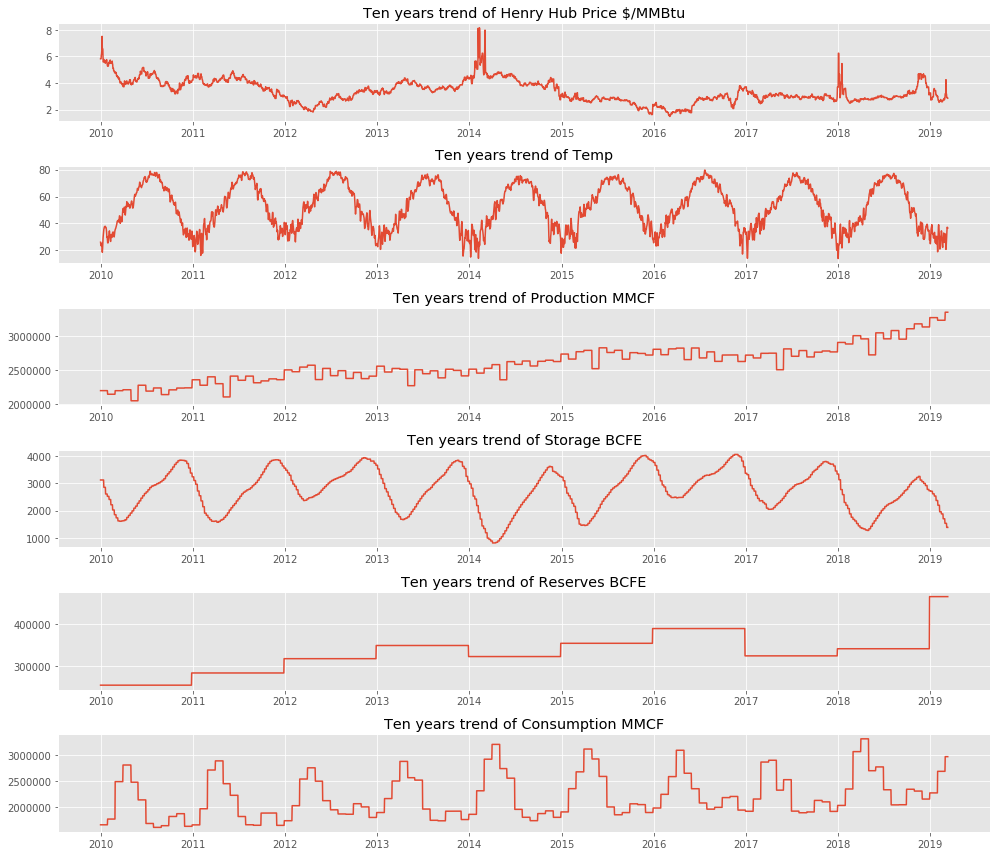

In [9]:
fig, axs = plt.subplots(len(data_columns), figsize=(14, 12))

for ax, column_name in zip(axs, data_columns):
    plot_trend_data(ax, column_name, df)
    
plt.tight_layout()

#### Some observations:

- the `price` plot shows a more random pattern than the others. it has a non-linear trend over time with some seasonal behaviour.
- The `temperature` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. 
- The `production` plot shows a general increase over time, probably influenced by the increase in shale plays production efficiencies.
- The `storage` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. In general, storage levels decrease during the winter and increase during the summer.
- The `reserves` plot shows a general increase over time, probably influenced by the increase in shale plays discoveries in the last few years.
- The `consumption` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. In general, natural gas consumption levels increase during the winter and decrease during the summer.

In [10]:
df.head()

,DateTime,Henry Hub Price $/MMBtu,Temp,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY
DateTime,,,,,,,,
2010-01-01,2010-01-01,5.82,26.0317,2197157.0,3117.0,255035.0,1666520.0,1
2010-01-02,2010-01-02,5.82,24.2249,2197157.0,3117.0,255035.0,1666520.0,2
2010-01-03,2010-01-03,5.82,23.5537,2197157.0,3117.0,255035.0,1666520.0,3
2010-01-04,2010-01-04,6.09,23.2831,2197157.0,3117.0,255035.0,1666520.0,4
2010-01-05,2010-01-05,6.19,24.5469,2197157.0,3117.0,255035.0,1666520.0,5


In [11]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Google Search Trend For {}".format(name))

def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=365):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

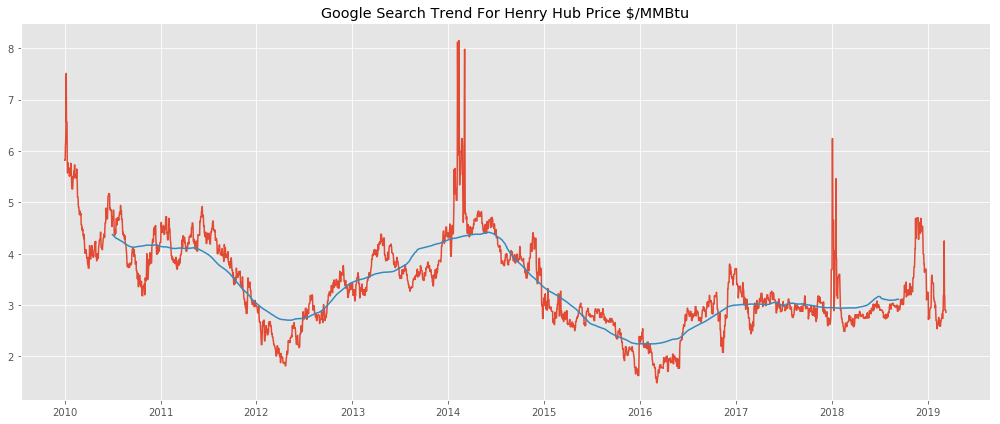

In [12]:
fig, axs = plt.subplots(figsize=(14, 6))
plot_moving_average_trend(axs, 'Henry Hub Price $/MMBtu', df['Henry Hub Price $/MMBtu'])
plt.tight_layout()


## Trend-Seasonal-Residual Decomposition

The Classical Trend-Seasonal-Residual Decomposition expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$


In [13]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

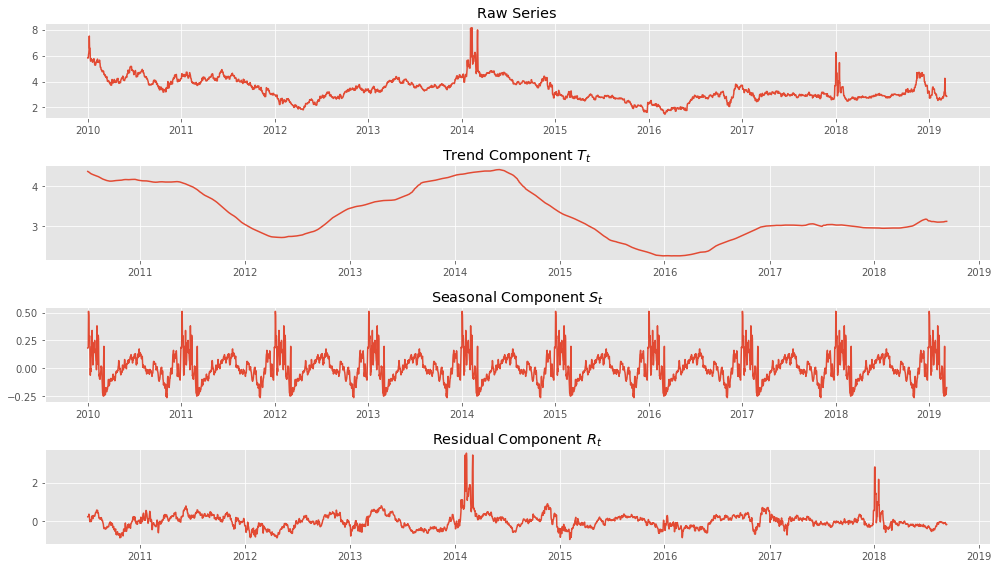

In [14]:
price_decomposition = sm.tsa.seasonal_decompose(df['Henry Hub Price $/MMBtu'], freq= 365)

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, df['Henry Hub Price $/MMBtu'], price_decomposition)
plt.tight_layout()

### Sharp increase in queries around wintertime, dropoff for queries around spring and fall, and slide increase for queries around summer.

# Stationary Analysis

### Rolling Statistic (Visual)

In [15]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    axs[2].set_ylim([-.5, .5])
    axs[2].plot(series.index, diff)
    axs[2].set_title("Series of First Differences: {}".format(title))

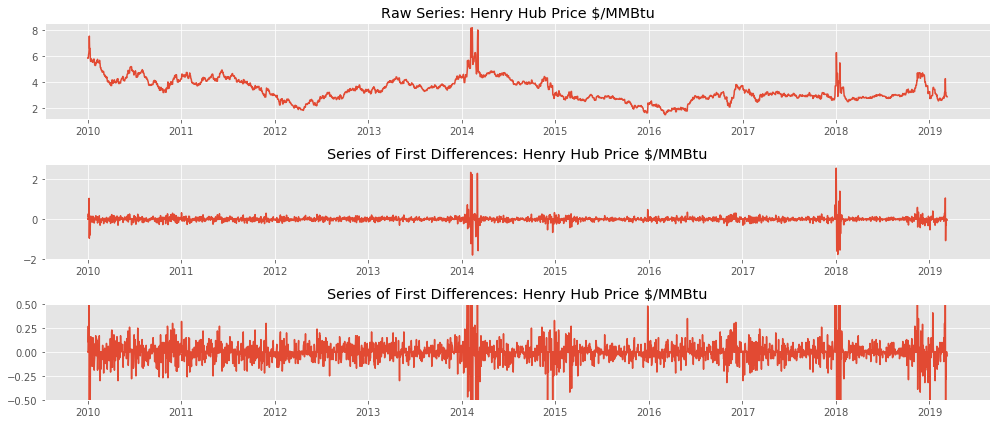

In [16]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_series_and_difference(axs, df['Henry Hub Price $/MMBtu'], 'Henry Hub Price $/MMBtu')
fig.tight_layout()

### Using `differencing` to make the data stationary and testing with the `Augmented Dickey-Fuller test`.

In [17]:
test = sm.tsa.stattools.adfuller(df['Henry Hub Price $/MMBtu'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.01


In [18]:
price_differences =df['Henry Hub Price $/MMBtu'].diff()[1:]
test = sm.tsa.stattools.adfuller(price_differences)
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

In [19]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

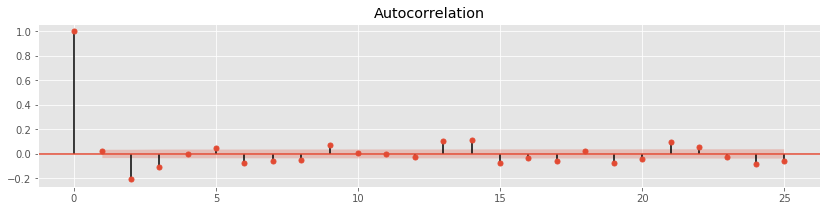

In [20]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_differences, lags=25, ax=ax)

(-0.1, 0.1)

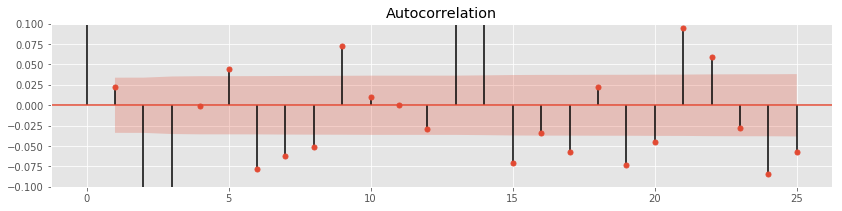

In [21]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_differences, lags=25, ax=ax)
ax.set_ylim([-.1, .1])

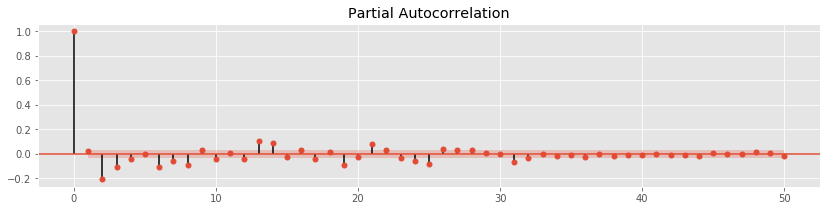

In [22]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_differences, lags=50, ax=ax, method='ywmle')

(-0.1, 0.1)

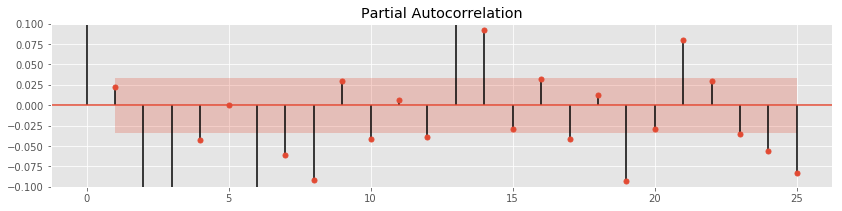

In [23]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_differences, lags=25, ax=ax, method='ywmle')
ax.set_ylim([-.1, .1])

Both the autocorrelation and the partial autocorrelation are showing oscillation due to the strong seasonality component.

For this reason we are going to try the SARIMA Model instead. 

# Testing for 5 years data

In [24]:
df_5y = df[df.DateTime > '2014-12-31']

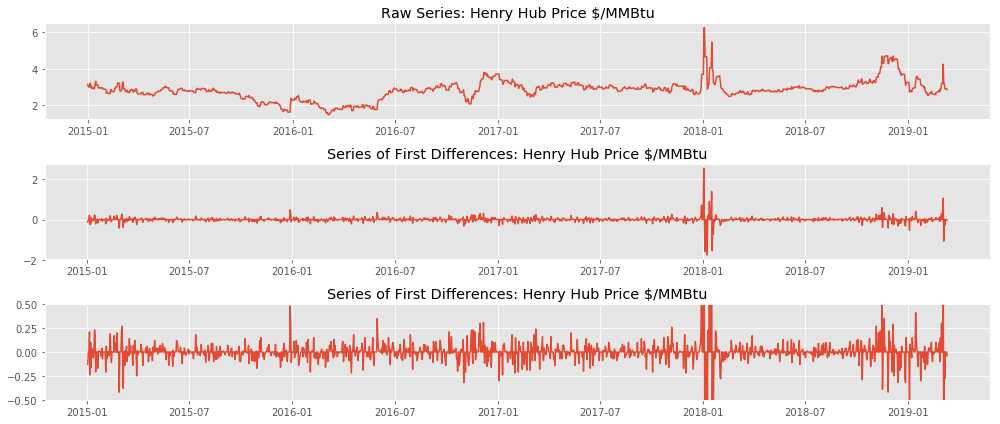

In [25]:
fig, axs = plt.subplots(3, figsize=(14, 6))
plot_series_and_difference(axs, df_5y['Henry Hub Price $/MMBtu'], 'Henry Hub Price $/MMBtu')
fig.tight_layout()

In [26]:
price_5y_differences =df_5y['Henry Hub Price $/MMBtu'].diff()[1:]
test = sm.tsa.stattools.adfuller(price_5y_differences)
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


This is telling as that the data became **stationary** after the first difference. 

(-0.25, 0.25)

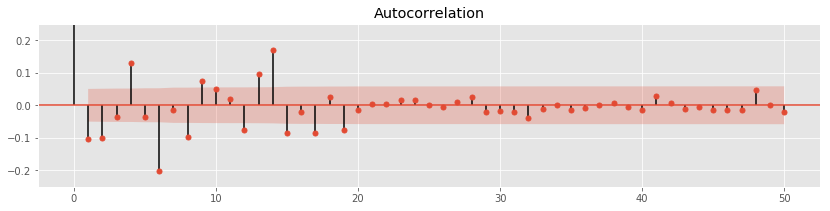

In [27]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_5y_differences, lags=50, ax=ax)
ax.set_ylim([-.25, .25])

(-0.25, 0.25)

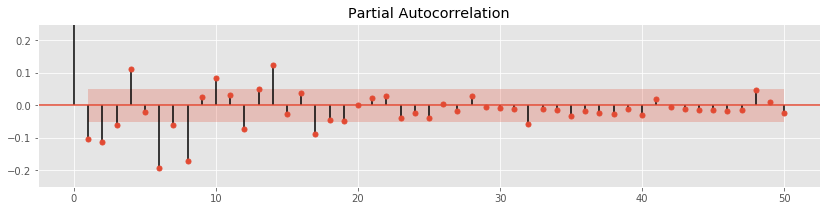

In [28]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_5y_differences, lags=50, ax=ax, method='ywmle')
ax.set_ylim([-.25, .25])

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

For the ARIMA model there is AR (significant lookback from the partial auto),I (The number of differences used to make the data stationary), and MA (significant lookback from the auto). In this case, it will be 2,1,2 respectively. However, it will be also interesting to use a (2,1,4), a (8,1,2), a (4,1,4), a (4,1,6), and a (8,1,6).

In [29]:
X = df_5y['Henry Hub Price $/MMBtu'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
price_model = ARIMA(history, order=(2, 1, 2))
price_model.fit(disp=0).forecast()[0]

array([2.63313154])

In [32]:
price_model

In [33]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [34]:
X = df_5y['Henry Hub Price $/MMBtu'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(test), yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.01407


In [35]:
X = df_5y['Henry Hub Price $/MMBtu'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(test), yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.01435


In [36]:
X = df_5y['Henry Hub Price $/MMBtu'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(test), yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test MSE: 0.01451


In [37]:
X = df_5y['Henry Hub Price $/MMBtu'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(8,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

KeyboardInterrupt: 

In [ ]:
X = df_5y['Henry Hub Price $/MMBtu'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('{} of {} predicted={}, expected={}'.format(t, len(test), yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

- ARIMA(1,1,0) = 0.01407 MSE
- ARIMA(2,1,0) = 0.01435 MSE
- ARIMA(2,1,2) = 0.01451 MSE
- ARIMA(8,1,2) = 0.01593 MSE
- ARIMA(4,1,4) = 0.01523 MSE

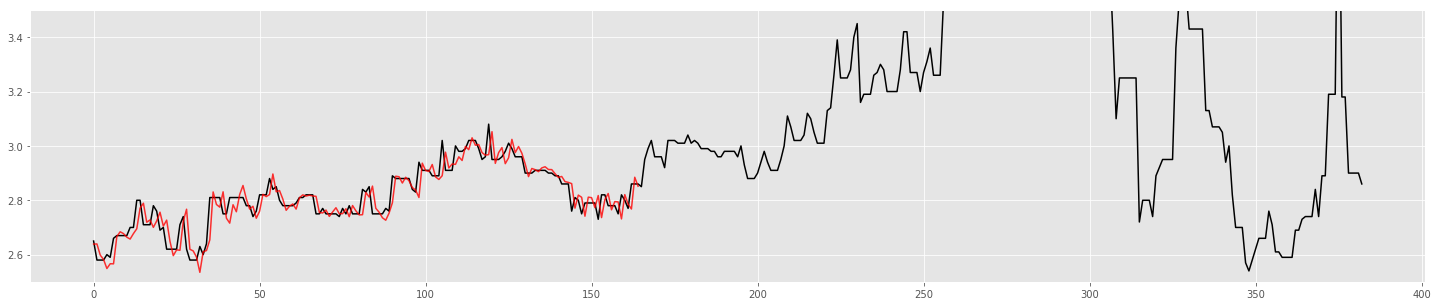

In [38]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black')
axs.plot(predictions, color='red', alpha = 0.8)
#axs.set_xlim([0, 100])
axs.set_ylim([2.5, 3.5])
plt.show()

In [39]:
X = df_5y['Henry Hub Price $/MMBtu']
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
model = ARIMA(train, order=(8, 1, 2)).fit()

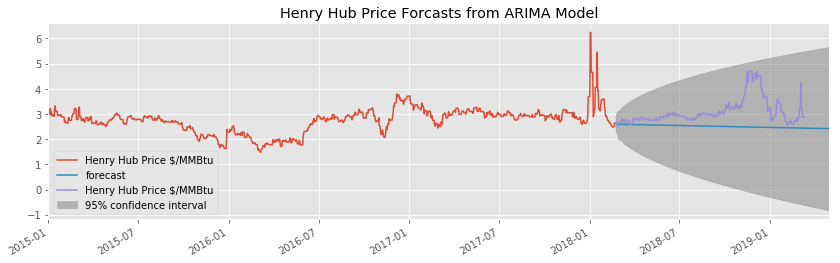

In [47]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(train['2010-10':].index, train['2010-10':])
fig = model.plot_predict('2018-02-22', '2019-05', 
                                  dynamic=True, ax=ax, plot_insample=False)
ax.plot(test)
_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
_ = ax.legend(loc="lower left")

_ = ax.set_title("Henry Hub Price Forcasts from ARIMA Model")
#ax.set_xlim([0, 40])
#ax.set_ylim([2.4, 3.5])

In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(model.resid, lags=50, ax=ax)

In [ ]:
df_pop = pd.read_csv('data/PEP_2017_PEPANNRES_with_ann.csv')

In [ ]:
df_pop.tail(2)

In [ ]:
def state(x):
    return x.split(',')[1].strip()

In [ ]:
df_pop['Geography'] = df_pop['Geography'].apply(lambda x : state(x))

In [ ]:
df_pop_group = df_pop.groupby(by= 'Geography').sum()

In [ ]:
df_pop_group.count()

In [ ]:
df_pop_group.head(2)